In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from astropy.io import fits

In [2]:
def normalise(arr):
    arr = np.asarray(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    return (arr - mean) / std
    
def discrete_cdf(data):
    unique_values, counts = np.unique(data, return_counts=True)
    cumulative_counts = np.cumsum(counts)
    cumulative_probabilities = cumulative_counts / cumulative_counts[-1]
    return unique_values, cumulative_probabilities

In [3]:
data_path = './default_drz-20250509T120401Z-001/default_drz/' 
hdu = fits.open('uncover-msa-default_drz-DR4.1-zspec.fits')

In [4]:
good_z_mask = hdu[1].data['flag_zspec_qual'] >= 2 
good_z_data = hdu[1].data[good_z_mask]

In [5]:
peak_at_656nm_indices = []
max_flux_wave_rest_array = []
max_flux_wave_obs_array = []
for index in range(len(good_z_data)):
    id_msa = good_z_data['id_msa'][index]
    z = good_z_data['z_spec'][index]
    spec_file = f'uncover_DR4_prism-clear_2561_{id_msa}.spec.fits'
    hdu_spec = fits.open(f'{data_path}{spec_file}')
    max_flux_index = np.nanargmax(hdu_spec[1].data['flux'])
    max_flux_wave_obs = hdu_spec[1].data['wave'][max_flux_index]
    max_flux_wave_rest = max_flux_wave_obs / (1 + z)
    if 0.63 < max_flux_wave_rest < 0.66: #ORIGINAL
    # if 0.64 < max_flux_wave_rest < 0.66:        
        peak_at_656nm_indices.append(index)
        max_flux_wave_rest_array.append(max_flux_wave_rest)
        max_flux_wave_obs_array.append(max_flux_wave_obs)

peak_at_656nm_indices = np.array(peak_at_656nm_indices)
max_flux_wave_rest_array = np.array(max_flux_wave_rest_array)
max_flux_wave_obs_array = np.array(max_flux_wave_obs_array)

bad_spec_z_data = good_z_data[peak_at_656nm_indices[max_flux_wave_rest_array < 0.64]]
bad_spec_id_msa = bad_spec_z_data['id_msa'][0] 
bad_spec_z = bad_spec_z_data['z_spec'][0] 
bad_spec_file = f'uncover_DR4_prism-clear_2561_{bad_spec_id_msa}.spec.fits'
bad_hdu_spec = fits.open(f'{data_path}{bad_spec_file}')

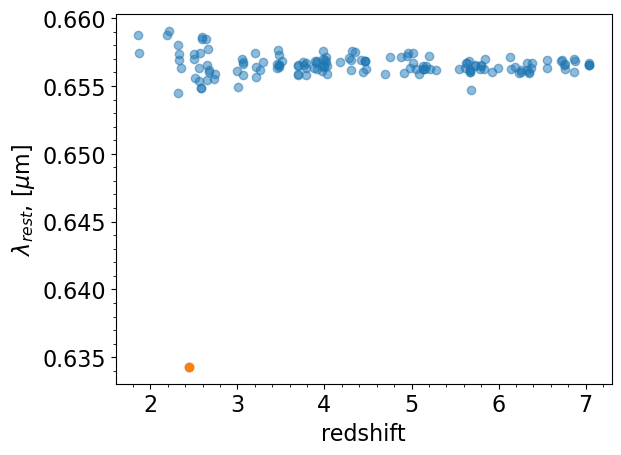

In [6]:
fig, ax = plt.subplots()
ax.scatter(good_z_data['z_spec'][peak_at_656nm_indices], max_flux_wave_rest_array, alpha = 0.5)
ax.scatter(good_z_data['z_spec'][peak_at_656nm_indices[max_flux_wave_rest_array < 0.64]], max_flux_wave_rest_array[max_flux_wave_rest_array < 0.64])
ax.set_xlabel('redshift', fontsize=16)
ax.set_ylabel(r'$\lambda_{rest}$, [$\mu$m]', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.minorticks_on()
fig.savefig('Fig_1.png', dpi = 150, bbox_inches='tight')

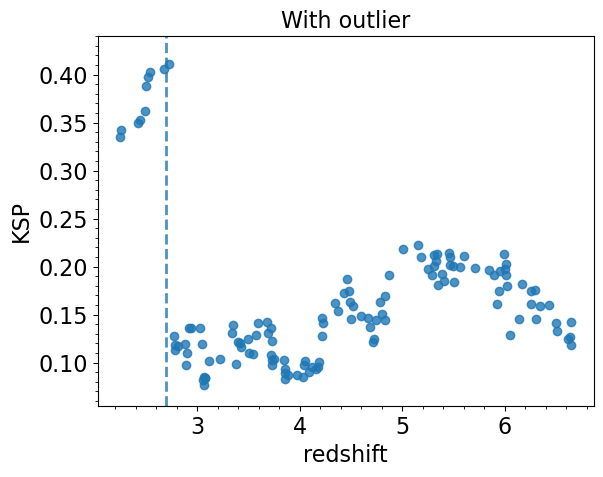

In [7]:
redshifts_sample = good_z_data['z_spec'][peak_at_656nm_indices]
sort_indices = np.argsort(redshifts_sample)
redshifts_sample = redshifts_sample[sort_indices]
wavelength_sample = np.array(max_flux_wave_rest_array)[sort_indices]

sample_size = 20
binned_ksp_stats = []
binned_redshift_means = []
for start_index in range(len(redshifts_sample) - sample_size):
    indices = np.arange(start_index, start_index + sample_size + 1)
    binned_wavelength_sample = wavelength_sample[indices]
    binned_redshifts_sample = redshifts_sample[indices]
    binned_wavelength_sample = normalise(binned_wavelength_sample)
    binned_ksp_stats.append(stats.kstest(binned_wavelength_sample, stats.norm.cdf))
    mean_redshift = (binned_redshifts_sample[0] + binned_redshifts_sample[-1]) / 2
    binned_redshift_means.append(mean_redshift)    

fig, ax = plt.subplots()
ax.scatter(binned_redshift_means, [ksp_stat.statistic for ksp_stat in binned_ksp_stats], alpha = 0.8)
ax.set_xlabel('redshift', fontsize=16)
ax.set_ylabel('KSP', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.axvline(x=2.7, linewidth=2, alpha = 0.8, linestyle='--')
ax.set_ylim(0.055, 0.44)
ax.minorticks_on()

ax.set_title('With outlier', fontsize=16)
fig.savefig('KSP_vs_redshift_with_outlier.png', dpi = 150, bbox_inches='tight')

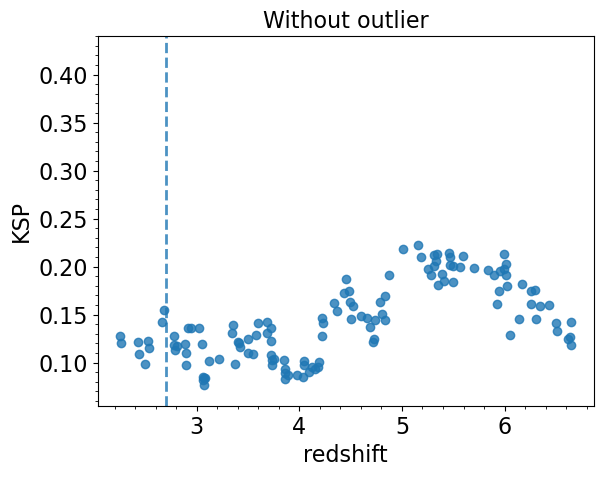

In [8]:
peak_at_656nm_indices = []
max_flux_wave_rest_array = []
max_flux_wave_obs_array = []
for index in range(len(good_z_data)):
    id_msa = good_z_data['id_msa'][index]
    z = good_z_data['z_spec'][index]
    spec_file = f'uncover_DR4_prism-clear_2561_{id_msa}.spec.fits'
    hdu_spec = fits.open(f'{data_path}{spec_file}')
    max_flux_index = np.nanargmax(hdu_spec[1].data['flux'])
    max_flux_wave_obs = hdu_spec[1].data['wave'][max_flux_index]
    max_flux_wave_rest = max_flux_wave_obs / (1 + z)
    # if 0.63 < max_flux_wave_rest < 0.66: #ORIGINAL
    if 0.64 < max_flux_wave_rest < 0.66:        
        peak_at_656nm_indices.append(index)
        max_flux_wave_rest_array.append(max_flux_wave_rest)
        max_flux_wave_obs_array.append(max_flux_wave_obs)

peak_at_656nm_indices = np.array(peak_at_656nm_indices)
max_flux_wave_rest_array = np.array(max_flux_wave_rest_array)
max_flux_wave_obs_array = np.array(max_flux_wave_obs_array)

redshifts_sample = good_z_data['z_spec'][peak_at_656nm_indices]
sort_indices = np.argsort(redshifts_sample)
redshifts_sample = redshifts_sample[sort_indices]
wavelength_sample = np.array(max_flux_wave_rest_array)[sort_indices]

sample_size = 20
binned_ksp_stats = []
binned_redshift_means = []
for start_index in range(len(redshifts_sample) - sample_size):
    indices = np.arange(start_index, start_index + sample_size + 1)
    binned_wavelength_sample = wavelength_sample[indices]
    binned_redshifts_sample = redshifts_sample[indices]
    binned_wavelength_sample = normalise(binned_wavelength_sample)
    binned_ksp_stats.append(stats.kstest(binned_wavelength_sample, stats.norm.cdf))
    mean_redshift = (binned_redshifts_sample[0] + binned_redshifts_sample[-1]) / 2
    binned_redshift_means.append(mean_redshift)    

fig, ax = plt.subplots()
ax.scatter(binned_redshift_means, [ksp_stat.statistic for ksp_stat in binned_ksp_stats], alpha = 0.8)
ax.set_xlabel('redshift', fontsize=16)
ax.set_ylabel('KSP', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.axvline(x=2.7, linewidth=2, alpha = 0.8, linestyle='--')
ax.set_ylim(0.055, 0.44)
ax.minorticks_on()

ax.set_title('Without outlier', fontsize=16)
fig.savefig('KSP_vs_redshift_without_outlier.png', dpi = 150, bbox_inches='tight')

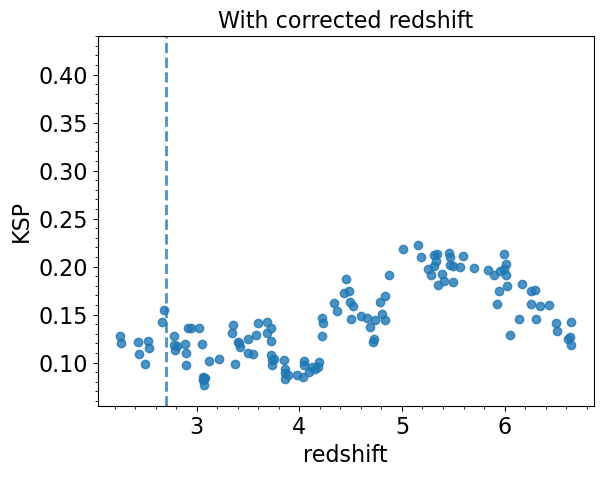

In [9]:
correct_redshift = 2.327594

peak_at_656nm_indices = []
max_flux_wave_rest_array = []
max_flux_wave_obs_array = []
for index in range(len(good_z_data)):
    id_msa = good_z_data['id_msa'][index]
    z = good_z_data['z_spec'][index]
    spec_file = f'uncover_DR4_prism-clear_2561_{id_msa}.spec.fits'
    hdu_spec = fits.open(f'{data_path}{spec_file}')
    max_flux_index = np.nanargmax(hdu_spec[1].data['flux'])
    max_flux_wave_obs = hdu_spec[1].data['wave'][max_flux_index]
    max_flux_wave_rest = max_flux_wave_obs / (1 + z)
    # if 0.63 < max_flux_wave_rest < 0.66: #ORIGINAL
    if 0.64 < max_flux_wave_rest < 0.66:        
        peak_at_656nm_indices.append(index)
        max_flux_wave_rest_array.append(max_flux_wave_rest)
        max_flux_wave_obs_array.append(max_flux_wave_obs)

peak_at_656nm_indices = np.array(peak_at_656nm_indices)
max_flux_wave_rest_array = np.array(max_flux_wave_rest_array)
max_flux_wave_obs_array = np.array(max_flux_wave_obs_array)

outlier_obs_wavelength = max_flux_wave_obs_array[max_flux_wave_rest_array < 0.64] 

redshifts_sample = good_z_data['z_spec'][peak_at_656nm_indices]
sort_indices = np.argsort(redshifts_sample)
redshifts_sample = redshifts_sample[sort_indices]
wavelength_sample = np.array(max_flux_wave_rest_array)[sort_indices]

wavelength_sample[wavelength_sample < 0.64] = outlier_obs_wavelength / (1 + correct_redshift)
redshifts_sample[wavelength_sample < 0.64] = correct_redshift

sample_size = 20
binned_ksp_stats = []
binned_redshift_means = []
for start_index in range(len(redshifts_sample) - sample_size):
    indices = np.arange(start_index, start_index + sample_size + 1)
    binned_wavelength_sample = wavelength_sample[indices]
    binned_redshifts_sample = redshifts_sample[indices]
    binned_wavelength_sample = normalise(binned_wavelength_sample)
    binned_ksp_stats.append(stats.kstest(binned_wavelength_sample, stats.norm.cdf))
    mean_redshift = (binned_redshifts_sample[0] + binned_redshifts_sample[-1]) / 2
    binned_redshift_means.append(mean_redshift)    

fig, ax = plt.subplots()
ax.scatter(binned_redshift_means, [ksp_stat.statistic for ksp_stat in binned_ksp_stats], alpha = 0.8)
ax.set_xlabel('redshift', fontsize=16)
ax.set_ylabel('KSP', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.axvline(x=2.7, linewidth=2, alpha = 0.8, linestyle='--')
ax.set_ylim(0.055, 0.44)
ax.minorticks_on()

ax.set_title('With corrected redshift', fontsize=16)
fig.savefig('KSP_vs_redshift_with_corrected_redshift.png', dpi = 150, bbox_inches='tight')